In [1]:
import pandas as pd
import csv
import os
import seaborn as sns
import numpy as np
from collections import defaultdict
import re

from sklearn.metrics import f1_score, classification_report

# GAB HATE CORPUS (Kennedy et al. 2020)
## Overall Results

In [99]:
results = {}
directory = '../../0_results/classification/'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue

In [167]:
# compare F1 by model

# calculate f1 
f1_types = ['macro', 'micro', 'weighted']
scores = {}

for key in results:
    if "1ep" in key or "base" in key:
        scores[key] = [f1_score(results[key]['label'], results[key]['prediction'], average=f1_type) for f1_type in f1_types]
    
pd.DataFrame.from_dict(scores, orient='index').rename(columns={0: f'{f1_types[0]} F1', 1: f'{f1_types[1]} F1', 2: f'{f1_types[2]} F1'}).sort_index().style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

,macro F1,micro F1,weighted F1
bert-base-rand,72.22%,91.39%,91.14%
bert-rand-10m-1ep-rand,73.05%,91.55%,91.35%
bert-rand-1m-1ep-rand,73.61%,91.64%,91.49%
bert-rand-2m-1ep-rand,72.81%,91.57%,91.32%
bert-rand-5m-1ep-rand,73.22%,91.70%,91.46%


## Results by Month

### Base Model

In [184]:
# f1 scores for base model finetuned on different months

results = {}
directory = '../../0_results/classification/ghc/month-models/base'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue


# calculate f1 
f1_type = 'macro'
scores = {}

for key in results :
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=f1_type)

score_series = {}
for model in sorted(pd.unique(pd.Series(scores.keys()).str[:18])):
    score_series[model] = []
    for key in sorted(scores):
        if model in key:
            score_series[model].append(scores[key])

out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})
out_df.columns = out_df.columns.str.replace('bert-base-', '')
out_df['model'] = out_df['model'].apply(lambda x: f'test-0{x+1}' if x+1!=10 else f'test-{x+1}')

out_df.set_index('model', inplace=True)

# write to df for later use
base_df = out_df.T.copy()

cm = sns.color_palette('Greens', as_cmap=True)

out_df.T.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

model,test-01,test-02,test-03,test-04,test-05,test-06,test-07,test-08,test-09,test-10
train-01,73.92%,64.76%,58.72%,62.67%,61.85%,61.18%,70.08%,65.36%,59.08%,70.08%
train-02,72.30%,69.21%,70.65%,65.76%,66.70%,68.33%,73.41%,68.33%,64.97%,72.43%
train-03,70.15%,70.66%,64.98%,58.41%,69.09%,67.65%,65.76%,70.19%,63.44%,71.14%
train-04,74.44%,73.41%,70.65%,68.62%,67.91%,69.30%,72.76%,70.19%,59.14%,71.57%
train-05,72.21%,70.15%,69.09%,64.57%,68.87%,66.17%,73.59%,67.03%,61.53%,77.50%
train-06,74.95%,70.64%,66.17%,64.06%,67.03%,66.17%,68.62%,63.28%,61.89%,74.99%
train-07,70.64%,64.90%,58.78%,66.24%,66.07%,66.32%,74.44%,66.17%,60.52%,71.15%
train-08,73.21%,70.64%,64.60%,65.80%,67.91%,68.16%,66.47%,72.67%,61.18%,71.63%
train-09,69.09%,69.30%,66.89%,71.85%,66.70%,65.31%,71.33%,65.36%,66.70%,68.94%
train-10,77.64%,68.76%,68.05%,71.63%,69.77%,71.06%,73.71%,68.16%,67.49%,69.35%


### Month-Adapted Models (matching)

In [194]:
# f1 scores for month-adapted models finetuned on different months

results = {}
directory = '../../0_results/classification/ghc/month-models/match'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue

# calculate f1 
f1_type = 'macro'
scores = {}

for key in results :
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=f1_type)

score_series = {}
for model in sorted(pd.unique(pd.Series(scores.keys()).str[:19])):
    score_series[model] = []
    for key in sorted(scores):
        if model in key:
            score_series[model].append(scores[key])

out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})
out_df.columns = out_df.columns.str.replace('bert-', '')
out_df['model'] = out_df['model'].apply(lambda x: f'test-0{x+1}' if x+1!=10 else f'test-{x+1}')

out_df.set_index('model', inplace=True)

# write to df for later use
adapted_df = out_df.T.copy()

cm = sns.color_palette('Greens', as_cmap=True)

out_df.T.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

model,test-01,test-02,test-03,test-04,test-05,test-06,test-07,test-08,test-09,test-10
01-1m-train-01,77.08%,65.80%,65.69%,65.38%,66.47%,64.60%,71.63%,64.18%,62.74%,68.16%
02-1m-train-02,76.91%,71.57%,68.05%,64.06%,67.09%,68.16%,73.41%,72.91%,61.18%,73.92%
03-1m-train-03,78.97%,66.87%,71.85%,65.38%,61.14%,68.45%,71.10%,73.41%,63.08%,75.46%
04-1m-train-04,80.10%,72.55%,69.30%,70.08%,67.91%,66.07%,72.67%,74.72%,60.84%,71.57%
05-1m-train-05,72.21%,71.15%,71.14%,68.62%,64.57%,69.57%,68.92%,70.08%,67.03%,71.63%
06-1m-train-06,72.78%,70.15%,70.64%,65.34%,65.36%,66.59%,65.80%,71.63%,63.28%,64.97%
07-1m-train-07,76.91%,66.24%,64.57%,64.97%,63.08%,67.65%,72.55%,68.76%,64.60%,70.66%
08-1m-train-08,73.21%,71.15%,73.06%,67.03%,65.76%,62.91%,71.96%,71.63%,62.54%,73.92%
09-1m-train-09,73.77%,71.15%,65.36%,74.99%,65.36%,71.14%,74.44%,64.18%,68.62%,72.05%
10-1m-train-10,76.32%,69.35%,72.61%,71.10%,65.95%,73.05%,71.96%,69.35%,69.35%,74.22%


### Month-Adapted Models (shifted)

In [195]:
# f1 scores for month-adapted models finetuned on different months

results = {}
directory = '../../0_results/classification/ghc/month-models/shift'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue

# calculate f1 
f1_type = 'macro'
scores = {}

for key in results :
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=f1_type)

score_series = {}
for model in sorted(pd.unique(pd.Series(scores.keys()).str[:19])):
    score_series[model] = []
    for key in sorted(scores):
        if model in key:
            score_series[model].append(scores[key])

out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})
out_df.columns = out_df.columns.str.replace('bert-', '')
out_df['model'] = out_df['model'].apply(lambda x: f'test-0{x+1}' if x+1!=10 else f'test-{x+1}')

out_df.set_index('model', inplace=True)

# write to df for later use
shift_adapted_df = out_df.T.copy()

cm = sns.color_palette('Greens', as_cmap=True)

out_df.T.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

model,test-01,test-02,test-03,test-04,test-05,test-06,test-07,test-08,test-09,test-10
02-1m-train-01,79.51%,69.09%,69.30%,67.03%,63.20%,63.88%,73.92%,67.65%,64.95%,69.67%
03-1m-train-02,72.67%,68.76%,67.09%,65.80%,73.23%,68.76%,74.96%,72.43%,65.76%,74.72%
04-1m-train-03,77.64%,66.47%,70.62%,64.57%,64.95%,67.49%,67.72%,69.74%,63.80%,73.71%
05-1m-train-04,80.12%,69.74%,70.20%,68.62%,67.49%,69.38%,70.66%,75.46%,67.65%,74.72%
06-1m-train-05,71.14%,67.48%,67.91%,61.89%,67.29%,69.67%,71.67%,68.42%,68.16%,71.57%
07-1m-train-06,76.72%,70.66%,69.67%,69.09%,62.74%,66.07%,72.14%,70.19%,60.84%,67.94%
08-1m-train-07,74.44%,66.70%,65.36%,62.91%,69.21%,68.33%,73.59%,70.66%,60.52%,73.06%
09-1m-train-08,74.35%,70.08%,70.64%,66.70%,67.29%,67.03%,76.12%,72.55%,65.80%,73.21%
10-1m-train-09,71.63%,68.42%,66.07%,74.99%,63.44%,72.05%,74.21%,67.29%,65.76%,71.57%


In [242]:
diffs = defaultdict(list)

for df, name in zip([base_df, adapted_df, shift_adapted_df], ['base', 'match-adapted', 'future-adapted']):
    diffs[name] = []
    
    print(name.upper(), '- difference in avg. macro F1 vsmat')
    for k in reversed(range(-5,6)):
        diff = np.diag(df).mean() - np.diag(df, k=k).mean()
        diffs[name].append(diff)
        print(f'train=test vs train{k}=test', '{:.2%}'.format(diff))
    print()

BASE - difference in avg. macro F1
train=test vs train5=test 1.21%
train=test vs train4=test 2.39%
train=test vs train3=test 2.37%
train=test vs train2=test 3.01%
train=test vs train1=test 3.63%
train=test vs train0=test 0.00%
train=test vs train-1=test 1.62%
train=test vs train-2=test 0.69%
train=test vs train-3=test 0.36%
train=test vs train-4=test 1.96%
train=test vs train-5=test 0.28%

MATCH-ADAPTED - difference in avg. macro F1
train=test vs train5=test 2.10%
train=test vs train4=test 2.14%
train=test vs train3=test 2.65%
train=test vs train2=test 3.87%
train=test vs train1=test 3.56%
train=test vs train0=test 0.00%
train=test vs train-1=test 1.96%
train=test vs train-2=test 1.15%
train=test vs train-3=test 0.06%
train=test vs train-4=test 2.15%
train=test vs train-5=test 0.27%

FUTURE-ADAPTED - difference in avg. macro F1
train=test vs train5=test 0.75%
train=test vs train4=test 1.77%
train=test vs train3=test 1.63%
train=test vs train2=test 2.18%
train=test vs train1=test 1.63%


<AxesSubplot:>

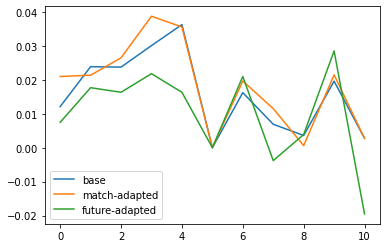

In [245]:
pd.DataFrame.from_dict(diffs).plot()

In [69]:
# difference in f1 scores between base and month-adapted models for each test case

(adapted_df-base_df.values).style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

model,test-01,test-02,test-03,test-04,test-05,test-06,test-07,test-08,test-09,test-10
01-1m-train-01,3.16%,1.04%,6.96%,2.71%,4.62%,3.42%,1.55%,-1.18%,3.66%,-1.92%
02-1m-train-02,4.61%,2.36%,-2.60%,-1.70%,0.39%,-0.17%,0.00%,4.58%,-3.79%,1.49%
03-1m-train-03,8.82%,-3.79%,6.88%,6.97%,-7.95%,0.80%,5.34%,3.22%,-0.35%,4.33%
04-1m-train-04,5.66%,-0.86%,-1.35%,1.46%,0.00%,-3.23%,-0.09%,4.53%,1.71%,0.00%
05-1m-train-05,0.00%,1.00%,2.05%,4.05%,-4.30%,3.40%,-4.67%,3.05%,5.50%,-5.87%
06-1m-train-06,-2.18%,-0.49%,4.47%,1.28%,-1.66%,0.42%,-2.81%,8.35%,1.39%,-10.02%
07-1m-train-07,6.27%,1.34%,5.78%,-1.28%,-2.99%,1.33%,-1.89%,2.59%,4.08%,-0.49%
08-1m-train-08,0.00%,0.51%,8.46%,1.22%,-2.14%,-5.26%,5.49%,-1.04%,1.36%,2.29%
09-1m-train-09,4.68%,1.85%,-1.52%,3.13%,-1.34%,5.82%,3.12%,-1.18%,1.92%,3.11%
10-1m-train-10,-1.32%,0.59%,4.56%,-0.53%,-3.83%,2.00%,-1.75%,1.19%,1.86%,4.86%


In [215]:
print('ACROSS ALL TRAIN/TEST COMBOS:')
print('average macro F1 for match-adapted models: {:.2%}'.format(adapted_df.values.mean()))
print('average macro F1 for base models: {:.2%}'.format(base_df.values.mean()))
print('difference: {:.2%}'.format(adapted_df.values.mean()-base_df.values.mean()))

print()
print('average macro F1 for future-adapted models: {:.2%}'.format(shift_adapted_df.values.mean()))

ACROSS ALL TRAIN/TEST COMBOS:
average macro F1 for match-adapted models: 69.29%
average macro F1 for base models: 68.12%
difference: 1.17%

average macro F1 for future-adapted models: 69.43%


In [214]:
print('FOR TRAIN=TEST MONTH:')
print('average macro F1 for match-adapted models: {:.2%}'.format(np.diag(adapted_df).mean()))
print('average macro F1 for base models: {:.2%}'.format(np.diag(base_df).mean()))
print('difference: {:.2%}'.format(np.diag(adapted_df).mean()-np.diag(base_df).mean()))
print()
print('average macro F1 for future-adapted models: {:.2%}'.format(np.diag(shift_adapted_df).mean()))

FOR TRAIN=TEST MONTH:
average macro F1 for match-adapted models: 70.88%
average macro F1 for base models: 69.49%
difference: 1.38%

average macro F1 for future-adapted models: 70.31%


In [226]:
k = 1

print(f'FOR TRAIN+{k}=TEST MONTH:')
print('average macro F1 for match-adapted models: {:.2%}'.format(np.diag(adapted_df, k=k).mean()))
print('average macro F1 for base models: {:.2%}'.format(np.diag(base_df, k=k).mean()))
print('difference: {:.2%}'.format(np.diag(adapted_df, k=k).mean()-np.diag(base_df, k=k).mean()))
print()
print('average macro F1 for future-adapted models: {:.2%}'.format(np.diag(shift_adapted_df, k=k).mean()))

FOR TRAIN+1=TEST MONTH:
average macro F1 for match-adapted models: 67.32%
average macro F1 for base models: 65.87%
difference: 1.45%

average macro F1 for future-adapted models: 68.68%


# GAB QIAN (Qian et al. 2019)
## Overall Results

In [169]:
results = {}
directory = '../../0_results/classification/gq'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue

In [178]:
# compare F1 by model

# calculate f1 
f1_types = ['macro', 'micro', 'weighted']
scores = {}

for key in results:
    if "rand" in key or "base" in key:
        scores[key] = [f1_score(results[key]['label'], results[key]['prediction'], average=f1_type) for f1_type in f1_types]
    
pd.DataFrame.from_dict(scores, orient='index').rename(columns={0: f'{f1_types[0]} F1', 1: f'{f1_types[1]} F1', 2: f'{f1_types[2]} F1'}).sort_index().style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

,macro F1,micro F1,weighted F1
bert-base-train-gq-test-gq,92.00%,92.09%,92.09%
bert-rand-10m-train-gq-test-gq,91.86%,91.95%,91.95%
bert-rand-1m-train-gq-test-gq,91.77%,91.86%,91.87%
bert-rand-2m-train-gq-test-gq,91.77%,91.86%,91.86%
bert-rand-5m-train-gq-test-gq,91.98%,92.07%,92.07%


In [175]:
# compare classification reports by model

for key in results:
    if "rand" in key or "base" in key:
        print(key.upper())
        print(classification_report(results[key]['label'], results[key]['prediction'], digits = 4))
        print()
              

BERT-RAND-1M-TRAIN-GQ-TEST-GQ
              precision    recall  f1-score   support

           0     0.9333    0.9189    0.9260      3638
           1     0.9009    0.9182    0.9095      2921

    accuracy                         0.9186      6559
   macro avg     0.9171    0.9185    0.9177      6559
weighted avg     0.9189    0.9186    0.9187      6559


BERT-RAND-5M-TRAIN-GQ-TEST-GQ
              precision    recall  f1-score   support

           0     0.9304    0.9263    0.9284      3638
           1     0.9088    0.9137    0.9112      2921

    accuracy                         0.9207      6559
   macro avg     0.9196    0.9200    0.9198      6559
weighted avg     0.9208    0.9207    0.9207      6559


BERT-RAND-10M-TRAIN-GQ-TEST-GQ
              precision    recall  f1-score   support

           0     0.9310    0.9233    0.9271      3638
           1     0.9055    0.9148    0.9101      2921

    accuracy                         0.9195      6559
   macro avg     0.9182    0.9190  

In [179]:
# compare F1 by model

# calculate f1 
f1_types = ['macro', 'micro', 'weighted']
scores = {}

for key in results:
    if "rand" not in key:
        scores[key] = [f1_score(results[key]['label'], results[key]['prediction'], average=f1_type) for f1_type in f1_types]
    
pd.DataFrame.from_dict(scores, orient='index').rename(columns={0: f'{f1_types[0]} F1', 1: f'{f1_types[1]} F1', 2: f'{f1_types[2]} F1'}).sort_index().style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

,macro F1,micro F1,weighted F1
bert-01_1m-train-gq-test-gq,91.82%,91.90%,91.91%
bert-02_1m-train-gq-test-gq,91.82%,91.90%,91.91%
bert-03_1m-train-gq-test-gq,91.85%,91.93%,91.94%
bert-04_1m-train-gq-test-gq,91.69%,91.78%,91.79%
bert-05_1m-train-gq-test-gq,91.75%,91.84%,91.85%
bert-06_1m-train-gq-test-gq,91.73%,91.81%,91.82%
bert-07_1m-train-gq-test-gq,91.72%,91.81%,91.82%
bert-08_1m-train-gq-test-gq,91.78%,91.87%,91.88%
bert-09_1m-train-gq-test-gq,91.80%,91.89%,91.89%
bert-10_1m-train-gq-test-gq,92.18%,92.27%,92.27%


---
# REDDIT POLITICAL SUBREDDIT PREDICTION (own data)

## Pilot Experiment: Results by Month

In [2]:
# f1 scores for month-adapted models finetuned on different months

F1_TYPE = 'macro'

results = {}
directory = '../../0_results/reddit/classification/z_old'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue
        
# calculate f1 
scores = {}

for key in results :
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=F1_TYPE)
    
score_series = {}
for model in sorted(pd.unique(pd.Series(scores.keys()).str[:21])):
    score_series[model] = {}
    for key in sorted(scores):
        if model in key:
            score_series[model][key[22:]] = scores[key]
            
out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})

out_df.set_index('model', inplace=True)

cm = sns.color_palette('Greens', as_cmap=True)

out_df.T.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

model,test-17-08,test-18-02,test-18-08,test-19-02,test-19-08,test-20-02
bert-base-train-17-08,47.69%,43.93%,38.82%,40.34%,37.95%,38.78%
bert-base-train-18-02,43.01%,46.53%,39.51%,42.49%,37.33%,39.29%
bert-base-train-18-08,42.68%,43.39%,41.89%,41.63%,38.19%,39.58%
bert-base-train-19-02,43.04%,42.28%,39.15%,43.94%,39.04%,40.60%
bert-base-train-19-08,40.72%,41.72%,38.67%,39.64%,42.51%,40.38%
bert-base-train-20-02,40.43%,40.57%,38.06%,39.62%,38.70%,44.25%


In [3]:
key = "bert-base-train-19-02-test-19-02"

print(key)

df_confusion = pd.crosstab(results[key]['label'], results[key]['prediction'], rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion.rename(index={0: 'chapo', 1: 'conservative', 2: 'libertarian', 3: 'the_donald', 4: 'politics'}, inplace=True)
df_confusion.rename(columns={0: 'chapo', 1: 'conservative', 2: 'libertarian', 3: 'the_donald', 4: 'politics'}, inplace=True)
df_confusion.style.background_gradient(cmap=cm, axis = 0, subset = pd.IndexSlice["chapo":"politics", "chapo":"politics"])

bert-base-train-19-02-test-19-02


Predicted,chapo,conservative,libertarian,the_donald,politics,All
Actual,,,,,,
chapo,438,126,156,168,112,1000
conservative,85,388,137,222,168,1000
libertarian,110,137,525,90,138,1000
the_donald,121,210,86,414,169,1000
politics,105,205,122,140,428,1000
All,859,1066,1026,1034,1015,5000


# Full Dataset
## Overall results

In [154]:
results = {}
directory = '../../0_results/reddit/classification/total-models'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
        continue
    else:
        continue

In [155]:
# compare F1 by number of finetuning cases for each model

def plot_F1(model_name):
    
    # calculate f1 
    f1_types = ['macro', 'micro', 'weighted']
    scores = {}

    for key in results:
        if model_name in key:
            scores[key] = [f1_score(results[key]['label'], results[key]['prediction'], average=f1_type) for f1_type in f1_types]

    plot_df = pd.DataFrame.from_dict(scores, orient='index').rename(columns={0: f'{f1_types[0]} F1', 1: f'{f1_types[1]} F1', 2: f'{f1_types[2]} F1'})
    plot_df.reset_index(inplace=True)
    plot_df['index'] = plot_df['index'].apply(lambda x: int(re.search(r'(.*?)_rand_(.*?)k-test_rand_10k', x).group(2))*1000 )
    plot_df.rename(columns={'index': "number of cases for finetuning"}, inplace=True)
    print(model_name.upper())
    display(plot_df.sort_values("number of cases for finetuning").style.\
            background_gradient(cmap=cm, axis = 0, subset=plot_df.columns[plot_df.columns!="number of cases for finetuning"])\
            .format('{0:,.2%}', subset=plot_df.columns[plot_df.columns!="number of cases for finetuning"]))
    print()
    
plot_F1("bert-base")
plot_F1("bert-rand_1m")
plot_F1("bert-rand_2m")
plot_F1("bert-rand_5m")

BERT-BASE


,number of cases for finetuning,macro F1,micro F1,weighted F1
4,1000,34.19%,34.31%,34.15%
5,4000,38.61%,38.38%,38.57%
3,20000,43.22%,43.01%,43.19%
1,40000,44.65%,44.50%,44.63%
0,80000,46.65%,46.56%,46.62%
2,160000,47.92%,47.87%,47.90%
6,320000,49.44%,49.37%,49.41%



BERT-RAND_1M


,number of cases for finetuning,macro F1,micro F1,weighted F1
4,1000,37.76%,37.72%,37.72%
6,4000,41.39%,41.34%,41.36%
1,20000,44.03%,43.78%,44.00%
0,40000,45.18%,45.00%,45.16%
3,80000,46.87%,46.74%,46.85%
2,160000,47.94%,47.85%,47.92%
5,320000,49.51%,49.40%,49.49%



BERT-RAND_2M


,number of cases for finetuning,macro F1,micro F1,weighted F1
6,1000,38.45%,38.41%,38.41%
5,4000,40.83%,40.75%,40.80%
2,20000,43.43%,43.20%,43.41%
3,40000,45.39%,45.16%,45.37%
1,80000,46.93%,46.75%,46.91%
4,160000,48.38%,48.29%,48.36%
0,320000,48.98%,48.92%,48.96%



BERT-RAND_5M


,number of cases for finetuning,macro F1,micro F1,weighted F1
1,1000,38.78%,38.84%,38.74%
3,4000,41.76%,41.62%,41.73%
5,20000,44.46%,44.15%,44.43%
4,40000,45.86%,45.60%,45.83%
2,80000,47.37%,47.26%,47.35%
6,160000,47.93%,47.87%,47.91%
0,320000,49.82%,49.72%,49.80%


In [156]:
# calculate f1 
F1_TYPE = 'macro'
scores = {}

for key in results:
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=F1_TYPE)
        
score_series = {}
for model in sorted(pd.unique(pd.Series(scores.keys()).apply(lambda x: x.split('-train')[0]))):
    score_series[model] = {}
    for key in sorted(scores):
        if model in key:
            score_series[model][int(re.search(r'(.*?)_rand_(.*?)k-test_rand_10k', key).group(2))*1000] = scores[key]
            #[key.split('-test')[0].split('bert-')[1].split('-')[1]] = scores[key]

In [157]:
out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})
out_df.set_index('model', inplace=True)

# write to df for later use
adapted_df = out_df.T.copy()

cm = sns.color_palette('Greens', as_cmap=True)

out_df.sort_index().T.style.background_gradient(cmap=cm, axis = None ).format('{0:,.2%}')

model,1000,4000,20000,40000,80000,160000,320000
bert-base,34.19%,38.61%,43.22%,44.65%,46.65%,47.92%,49.44%
bert-rand_1m,37.76%,41.39%,44.03%,45.18%,46.87%,47.94%,49.51%
bert-rand_2m,38.45%,40.83%,43.43%,45.39%,46.93%,48.38%,48.98%
bert-rand_5m,38.78%,41.76%,44.46%,45.86%,47.37%,47.93%,49.82%


## Results by Month: INDIVIDUAL MODELS

In [163]:
# f1 scores for base and month-adapted models finetuned on different months

def plot_F1_monthly(F1_TYPE, MODEL_TYPE, YEAR_FILTER = ["2017", "2018", "2019", "2020"]):
    results = {}
    directory = f'../../0_results/reddit/classification/month-models/{MODEL_TYPE}'
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, filename))
            continue
        else:
            continue

    # calculate f1 
    scores = {}

    for key in results :
        scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=F1_TYPE)

    score_series = {}
    for model in sorted(pd.unique(pd.Series(scores.keys()).apply(lambda x: re.search(r'(.*?)-test(.*?)', x).group(1)))):
        if any("_"+year in model for year in YEAR_FILTER):
            score_series[model] = {}
            for key in sorted(scores):
                if model in key and any("_"+year in re.search(r'(.*?)k-(.*)', key).group(2) for year in YEAR_FILTER):
                    score_series[model][re.search(r'(.*?)k-(.*)_5k', key).group(2)] = scores[key]

    out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})

    out_df.set_index('model', inplace=True)

    cm = sns.color_palette('Greens', as_cmap=True)

    display(out_df.T.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}'))

plot_F1_monthly(F1_TYPE = 'macro', MODEL_TYPE = 'base', YEAR_FILTER = ["2019"])

model,test_2019_01,test_2019_02,test_2019_03,test_2019_04,test_2019_05,test_2019_06,test_2019_07,test_2019_08,test_2019_09,test_2019_10,test_2019_11,test_2019_12
bert-base-train_2019_01_20k,44.61%,42.01%,42.71%,42.01%,42.62%,41.38%,41.94%,39.40%,41.86%,41.70%,41.20%,41.81%
bert-base-train_2019_02_20k,42.03%,43.83%,42.57%,42.82%,44.42%,42.15%,41.04%,40.10%,41.89%,42.25%,39.81%,41.23%
bert-base-train_2019_03_20k,41.30%,41.97%,43.84%,43.81%,43.67%,41.78%,40.47%,39.56%,41.35%,41.09%,40.38%,41.07%
bert-base-train_2019_04_20k,42.01%,42.45%,42.82%,45.26%,43.49%,41.69%,42.29%,40.43%,42.06%,41.59%,40.34%,43.01%
bert-base-train_2019_05_20k,42.44%,43.02%,42.86%,43.75%,45.55%,41.86%,41.15%,40.08%,41.09%,42.06%,41.22%,42.17%
bert-base-train_2019_06_20k,41.81%,42.03%,41.95%,42.96%,43.72%,43.19%,41.99%,40.74%,41.92%,42.21%,41.46%,40.88%
bert-base-train_2019_07_20k,41.93%,42.13%,42.02%,43.62%,43.25%,41.10%,43.51%,41.12%,41.19%,42.03%,41.22%,42.02%
bert-base-train_2019_08_20k,40.41%,41.22%,41.30%,42.18%,42.36%,41.06%,42.16%,42.24%,41.32%,42.28%,40.62%,41.59%
bert-base-train_2019_09_20k,41.56%,41.86%,41.04%,42.39%,42.45%,42.27%,41.94%,41.06%,43.43%,43.81%,41.34%,43.53%
bert-base-train_2019_10_20k,41.64%,42.23%,42.47%,43.16%,43.63%,41.79%,41.52%,39.36%,42.48%,45.12%,42.29%,43.02%


In [164]:
plot_F1_monthly('macro', 'match', YEAR_FILTER = ["2019"])

model,test_2019_01,test_2019_02,test_2019_03,test_2019_04,test_2019_05,test_2019_06,test_2019_07,test_2019_08,test_2019_09,test_2019_10,test_2019_11,test_2019_12
bert-2019_01_1m-train_2019_01_20k,43.08%,43.00%,42.51%,43.66%,43.30%,42.41%,42.05%,41.56%,41.16%,41.33%,41.60%,42.99%
bert-2019_02_1m-train_2019_02_20k,43.14%,44.24%,43.53%,43.29%,44.77%,43.25%,42.06%,40.36%,42.33%,42.37%,41.82%,42.64%
bert-2019_03_1m-train_2019_03_20k,42.71%,42.54%,44.19%,44.05%,43.91%,41.87%,40.79%,40.20%,41.60%,43.01%,41.31%,42.28%
bert-2019_04_1m-train_2019_04_20k,42.73%,43.29%,42.87%,45.36%,43.99%,42.44%,42.29%,40.68%,42.26%,40.77%,40.89%,42.67%
bert-2019_05_1m-train_2019_05_20k,42.87%,43.10%,43.22%,44.72%,46.14%,42.66%,42.02%,40.74%,43.12%,42.55%,42.39%,42.36%
bert-2019_06_1m-train_2019_06_20k,42.44%,41.74%,41.92%,42.64%,44.10%,44.10%,41.81%,41.23%,42.28%,42.65%,41.27%,41.43%
bert-2019_07_1m-train_2019_07_20k,41.58%,41.66%,41.98%,43.48%,43.08%,41.73%,44.31%,41.36%,42.67%,42.46%,41.57%,41.40%
bert-2019_08_1m-train_2019_08_20k,41.23%,42.41%,41.35%,42.96%,42.75%,40.90%,42.20%,43.46%,42.69%,42.43%,41.23%,41.98%
bert-2019_09_1m-train_2019_09_20k,41.71%,41.79%,42.12%,43.06%,42.98%,42.00%,41.30%,41.99%,45.47%,44.89%,43.53%,43.27%
bert-2019_10_1m-train_2019_10_20k,41.91%,42.28%,42.05%,43.14%,43.75%,42.05%,42.71%,41.12%,43.79%,46.65%,43.62%,43.65%


## Results by Month: MODEL COMPARISON

In [133]:
%%time 

results = {}
directory = '../../0_results/reddit/classification/month-models'

for foldername in ["base", "match", "ada-rand", "train-rand"]:
    for filename in os.listdir(os.path.join(directory, foldername)):
        if filename.endswith(".csv"):
            results[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(directory, foldername, filename))
            
            
# calculate f1 
F1_TYPE = 'macro'

scores = {}

for key in results :
    scores[key] = f1_score(results[key]['label'], results[key]['prediction'], average=F1_TYPE)
    
month_scores = {}
for test_month in sorted(pd.unique(pd.Series(scores.keys()).apply(lambda x: re.search(r'(.*?)20k-(.*)', x).group(2)))):
    month_scores[test_month] = { model: scores[model] for model in scores if (test_month in model.lower())}

RESULTS:
1) base + rand finetune --> bert-base-train_rand_20k
2) rand adapt + rand finetune --> bert-rand_1m-train_rand_20k
3) month adapt + rand finetune --> bert-2017_03_1m-train_rand_20k
4) base + month finetune --> bert-base-train_2017_03_20k
5) rand adapt + month finetune --> bert-rand_1m-train_2017_03_20k
6) month adapt + month finetune --> bert-2017_03_1m-train_2017_03_20k

In [139]:
filter_scores = {}
for test_month in month_scores:
    filter_list = {"bert-base-train_rand_20k": "base+rand",
                   f"bert-base-train_{re.search(r'(.*?)_(.*?)_5k', test_month).group(2)}_20k": "base+month",
                   "bert-rand_1m-train_rand_20k": "rand+rand",
                   f"bert-rand_1m-train_{re.search(r'(.*?)_(.*?)_5k', test_month).group(2)}_20k": "rand+month",
                   f"bert-{re.search(r'(.*?)_(.*?)_5k', test_month).group(2)}_1m-train_rand_20k": "month+rand",
                   f"bert-{re.search(r'(.*?)_(.*?)_5k', test_month).group(2)}_1m-train_{re.search(r'(.*?)_(.*?)_5k', test_month).group(2)}_20k": "month+month"}
                   
    filter_scores[f"{re.search(r'test_(.*?)_5k',test_month).group(1)}"] = \
    {filter_list[f"{re.search(r'(.*?)-test(.*)', model).group(1)}"]: scores[model] for model in month_scores[test_month] if any(fil in model for fil in filter_list.keys())}

month_results_df = pd.DataFrame.from_dict(filter_scores, orient = "index")
#month_results_df.index.rename('test_month', inplace=True)

month_results_df = month_results_df[['base+rand', 'rand+rand', 'month+rand', 'base+month', 'rand+month', 'month+month']]

month_results_df.style.background_gradient(cmap=cm, axis = 1 ).format('{0:,.2%}')

,base+rand,rand+rand,month+rand,base+month,rand+month,month+month
2017_03,45.75%,45.85%,46.29%,49.45%,50.57%,51.03%
2017_04,46.28%,46.68%,47.04%,49.43%,50.03%,50.29%
2017_05,45.08%,46.39%,45.28%,50.01%,49.71%,49.84%
2017_06,45.43%,45.93%,46.70%,48.60%,48.97%,49.07%
2017_07,46.95%,47.27%,47.35%,49.55%,50.09%,49.94%
2017_08,44.45%,44.11%,44.75%,47.12%,47.54%,47.77%
2017_09,45.27%,45.42%,45.74%,47.92%,48.35%,48.70%
2017_10,44.31%,45.41%,45.58%,46.51%,48.09%,47.29%
2017_11,45.81%,45.33%,45.32%,47.27%,48.84%,48.72%
2017_12,44.25%,44.47%,45.02%,46.43%,47.14%,47.39%


In [143]:
pd.DataFrame(month_results_df.mean(axis=0)).rename(columns={0: "avg. macro F1 across months"}).style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2%}')

,avg. macro F1 across months
base+rand,43.21%
rand+rand,43.84%
month+rand,43.81%
base+month,45.41%
rand+month,46.02%
month+month,46.12%


In [153]:
def avg_diff(model1, model2):
    print(f"avg. macro F1 diff. between {model1} and {model2}")
    print("{:.2%}".format((month_results_df[model1]-month_results_df[model2]).mean()))
    
avg_diff('month+month', 'base+rand')

avg. macro F1 diff. between month+month and base+rand
2.91%
